In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy
%matplotlib notebook 
print(astropy.__version__)
if int(astropy.__version__.split(".")[0]) < 2.:
    raise RuntimeError("This notebook only works for astropy version > 2")

3.2.1


### 1. Establish Palomar as location for obs

In [10]:
from astroplan import Observer, FixedTarget, observability_table
from astropy.time import Time

Palomar = Observer.at_site("Palomar")
Paranal = Observer.at_site("Paranal")

### 2. Read in targets as each PTF field

In [11]:
from astropy.table import Table
target_table = Table.read('fields.txt', format='ascii')
tar_tab = target_table[['%ID', 'RA', 'Dec']]
from astropy.coordinates import SkyCoord, get_moon, get_sun
import astropy.units as u
targets = [FixedTarget(coord=SkyCoord(ra=ra*u.deg, dec=dec*u.deg), name=name)
           for name, ra, dec in tar_tab]
#print(targets)

### 3. Establish constraints [will need to be repeated on nightly basis]

In [12]:
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint, MoonSeparationConstraint)

### 4. Loop over every night in 1 year 

In [13]:
from astroplan import time_grid_from_range
times = time_grid_from_range(Time(["2019-10-28 00:00", "2020-04-15 00:00"]), time_resolution=1*u.day)

I find that measuring the angle between the moon and a fixed position in RA and Dec is wildly different from measuring the position between that fied position and the moon. My (outside of Python/astropy) calculations show that the later produces correct answers while the former does not. The `astroplan` MoonSeparationConstraint class does the former, so I have altered it below to calculate the expected results. 

In [19]:
# hr_in_night = np.zeros(len(times))
##ALWAYS CHECK WHAT THE OBSERVER SITE IS: PALOMAR NOT PARANAL, YOU FOOL!
times = time_grid_from_range(Time(["2019-10-28 00:00", "2020-01-15 00:00"]), time_resolution=1*u.day)
#times = time_grid_from_range(Time(["2018-01-01 00:00", "2019-01-01 00:00"]), time_resolution=1*u.day)
AAMfield_observability = np.zeros((len(targets),len(times)))
#AAMfield_observability_preZUDS = np.zeros((len(targets),len(times)))

for time_num, time in enumerate(times):
    sun_moon_angle_norm = get_moon(time, location=Palomar.location).separation(get_sun(time)).radian/np.pi
    constraints = [AirmassConstraint(2.0), 
                   AtNightConstraint.twilight_astronomical(), 
                   MoonSeparationConstraint(sun_moon_angle_norm**2*(55*u.deg))]
    AAMfield_observability[:,time_num] = observability_table(constraints, 
                                                          Palomar, targets, 
                                                          time_range=[time, time + 1*u.day], 
                                                          time_grid_resolution = 1*u.minute)["fraction of time observable"]


In [20]:
airmass2_0 = pd.DataFrame(AAMfield_observability, index = np.arange(len(targets)) + 1)
airmass2_0.to_hdf("airmass2_0.h5", "d1")
np.savetxt('Palomar_AllObservability_EndOctJan.txt', AAMfield_observability)
print(np.shape(AAMfield_observability))


(1778, 79)


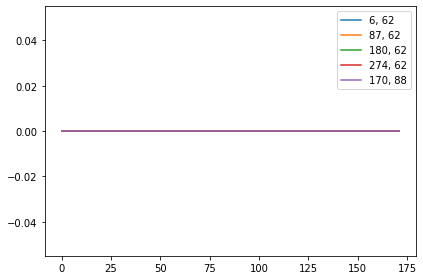

In [9]:
plt.figure()
# plot equatorial fields
#plt.plot(AAMfield_observability[395]*24, label = "1.7, -2.6")
#plt.plot(AAMfield_observability[409]*24, label = "93, -2.6")
#plt.plot(AAMfield_observability[421]*24, label = "178, -2.6")
#plt.plot(AAMfield_observability[434]*24, label = "270, -2.6")

# plot dec = 30 fields
# plt.plot(AAMfield_observability[648]*24, label = "0.5, 33")
# plt.plot(AAMfield_observability[659]*24, label = "86, 33")
# plt.plot(AAMfield_observability[671]*24, label = "180, 33")
# plt.plot(AAMfield_observability[683]*24, label = "274, 33")

# plot dec = 60 fields
plt.plot(AAMfield_observability[805]*24, label = "6, 62")
plt.plot(AAMfield_observability[811]*24, label = "87, 62")
plt.plot(AAMfield_observability[818]*24, label = "180, 62")
plt.plot(AAMfield_observability[825]*24, label = "274, 62")
plt.plot(AAMfield_observability[-1]*24, label = "170, 88")
plt.legend()
plt.tight_layout()

#np.savetxt("field_observability.txt", AAMfield_observability)




76 [266, 267, 314, 580, 628, 629, 630, 673, 674, 675, 676, 677, 678, 716, 717, 718, 719, 720, 721, 747, 751, 753, 754, 755, 756, 757, 758, 759, 760, 761, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 814, 816, 817, 818, 819, 820, 821, 822, 823, 824, 838, 839, 840, 842, 843, 844, 845, 846, 847, 858, 859, 860, 861, 862, 863, 864, 870, 871, 872, 874, 875, 876]


Text(0, 0.5, 'Hours visible')

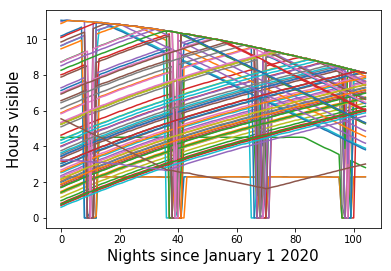

In [15]:
field_list = []
field_index = []
field_perc_obs = []
ebv_tar = target_table['Ebv']
n_hr = 2
frac = .9
AAM_Nov = AAMfield_observability
for i, fieldval in enumerate(AAM_Nov):
    obs_1hr = fieldval[fieldval > n_hr/24]
    perc_obs = len(obs_1hr)/len(fieldval)
    if  perc_obs > frac and i < 879 and ebv_tar[i] <= 0.1:
        #print(i)
        field_list.append(fieldval)
        field_index.append(int(i+1))
        field_perc_obs.append(perc_obs)
        #field_col = tar_tab[tar_tab['%ID'] == fieldval]
        plt.plot(AAMfield_observability[i+1]*24, label = str(i+1))
print(len(field_index), field_index)
np.savetxt('FieldLists/JanApr_fieldList_'+str(n_hr)+'hr'+str(frac)+'fracTime.txt', np.array(field_index))
#plt.legend(loc=0, prop={'size':6})
plt.xlabel('Nights since January 1 2020', fontsize=15)
plt.ylabel('Hours visible', fontsize=15)

/Users/suhaildhawan/anaconda2/envs/mypy3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


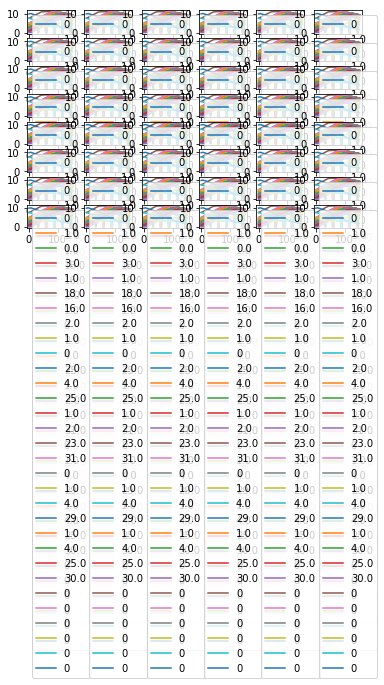

In [9]:
import matplotlib.gridspec as gridspec

n_iband_exp = np.loadtxt('out.dat', delimiter='|', skiprows=2)
#set the field indices as integers
n_iband_exp[:,0] = n_iband_exp[:,0].astype('int')
frank = []
gs = gridspec.GridSpec(8, 6)
counter = 0
#print(n_iband_exp,n_iband_exp[:,0] == fval)
np.savetxt('AllObservability.txt', AAMfield_observability)
for fval in field_index:
    for kval in range(8):
        for rval in range(6):
            ax = plt.subplot(gs[kval, rval])
            obs_val = AAMfield_observability[fval]
            if fval not in n_iband_exp[:,0]:
                n_image = 0
            else:
                n_image = n_iband_exp[n_iband_exp[:,0] == fval][0][1]
            ax.plot(obs_val*24, label=str(n_image))
            ax.legend(loc=0)
    counter += 1

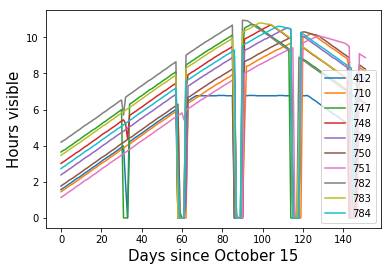

In [10]:
fig2 = plt.figure(2)
for i in field_index[:10]:
    plt.plot(AAMfield_observability[i]*24., label = str(i))
#plt.cla()
plt.legend(loc=0)
plt.xlabel("Days since October 15", fontsize=15)
plt.ylabel("Hours visible", fontsize=15)
plt.savefig("visibility_first10_2hr_91perc.pdf")

IndexError: list index out of range

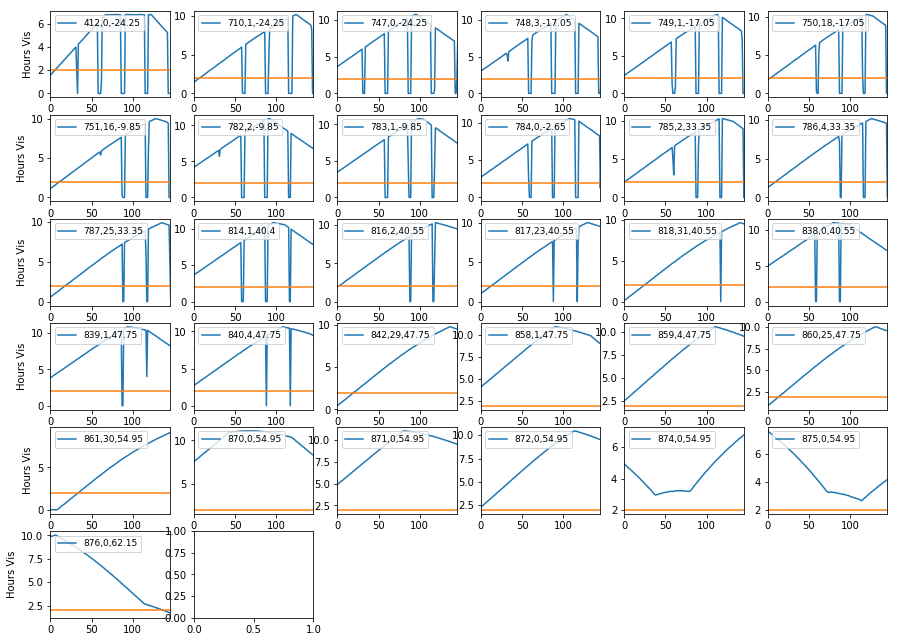

In [11]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(8,6)
aam = AAMfield_observability
fig = plt.figure(1, figsize=(15,15))
fields = np.loadtxt('radec_Feb_2hrVis0.87frac.txt')
counter = 0
for kval in range(8):
    for rval in range(6):
        ax = plt.subplot(gs[kval, rval])
        fid = field_index[counter]
        obs_val = aam[int(fid)]
        if int(fid) in n_iband_exp[:,0]:
            n_image = n_iband_exp[n_iband_exp[:,0] == fid][0][1] 
        else:
            n_image = 0
        #fields = 
        ax.plot(obs_val*24., label=str(int(fid))+','+str(int(n_image))+','+str(fields[counter][2]))
        ax.plot([0, 150],[2,2]) 
        ax.set_xlim(0, 145)
        counter+= 1
        ax.legend(loc=2, prop={'size':9})
        if kval > 6:
            ax.set_xlabel('Days since 15-10-2019')
        if rval == 0:
            ax.set_ylabel('Hours Vis')
plt.savefig('ZUDS_2hr087_VisPlot.pdf')
